# Parameter definition

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Functions
def rangewf(start, stop, step):
    while stop > start:
        yield start
        start += step

# Echem rxn properties
ethy_FE   = 50                   # %
J_tot     = 0.5                  # A/cm^2 (total current density)
ethy_prod = 2000000              # tons per annum of ethylene

pH_CL     = 13.2                 # pH at CL due to the CL-IP gradient
pH_IP     = 4                    # pH at CL due to the IP-BPM gradient

r_h2      = 8274                 # mol/s
r_c2h4    = 2298                 # mol/s
r_EtOH    = 1021                 # mol/s

delHf_h2  = 0                    # kJ/mol
delHf_c2h4= -64                  # kJ/mol
delHf_EtOH= -86.7                # kJ/mol

SRPV_h2  = 0                     # V
SRPV_c2h4= 0.084                 # V
SRPV_EtOH= 0.064                 # V
SRPV_O2  = 1.23                  # V
SRPV_WDR = 0                     # V
overP_anod= 1                  # V
overP_cath= 1                  # V

V_SRP = SRPV_O2 - (SRPV_h2 + SRPV_c2h4 + SRPV_EtOH)
V_overp = overP_anod + overP_cath
V_nernst= 0.059 * (pH_CL - pH_IP)

# Stack heating param defn

rho_bp    = 0.00007              # ohm.cm [SS316 resistivity]
x_bp      = 0.2                  # cm
rho_gdl   = 0.013                # ohm.cm^2 [39 bb]
rho_bpm   = 4                    # ohm.cm^2 [39 bb]
crho_bp   = 0.005                # ohm.cm^2 [contact resistance BP-GDL]
rho_ip    = 50                   # ohm.cm
x_ip      = 0.0135               # cm
crho_ip   = 0.005                # ohm.cm^2 [contact resistance IP-GDL]

# Stack sizing

cell_num  = 150
cell_area = 3.5                  # m^2

# contants
F = 96845                        # Faraday's constant
T = 298.15                       # K          
R = 8.314                        # J/kmol/K

# Variable defn, calculations

## BPM polarization curve LR model

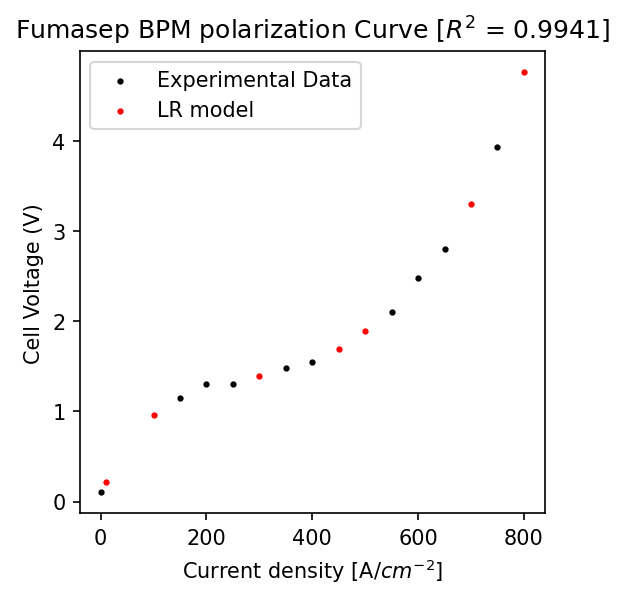

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

currden = np.array([1, 10, 100, 200, 300, 400, 500, 600, 700, 800, 150, 250, 350, 450, 550, 650, 750])
bpmvolt = np.array([0.1, 0.41, 1.08, 1.30, 1.38, 1.55, 1.90, 2.48, 3.33, 4.62, 1.15, 1.3, 1.48, 1.7, 2.1, 2.8, 3.93])

np.random.seed(0)

x_train, x_test, y_train, y_test = train_test_split(currden, bpmvolt, test_size=0.4)

def rbf(x_train, x_test=None, gamma=0.0000002):
    if x_test is None:
        x_test = x_train
    N = len(x_test) #<- number of data points
    M = len(x_train) #<- number of features
    X = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            X[i,j] = np.exp(-gamma*(x_test[i] - x_train[j])**2)
    return X

model = LinearRegression(fit_intercept=False) 

X_train = rbf(x_train)
model.fit(X_train, y_train) 

X_test = rbf(x_train, x_test)
bpmvolt_pred = []

for i in X_test:
    arr = np.array(i)
    bpmvolt_pred.append(model.predict(arr.reshape(1,-1)))

r2 = round(model.score(X_test, y_test),4)

fig, ax = plt.subplots(figsize = (4,4), dpi = 150)
ax.scatter(x_train, y_train, s=4, c='black')
ax.scatter(x_test, bpmvolt_pred, s=4, c='red')
ax.set_xlabel('Current density [A/$cm^{-2}$]')
ax.set_ylabel('Cell Voltage (V)')
ax.set_title('Fumasep BPM polarization Curve [$R^{2}$ = '+str(r2)+']')
ax.legend(['Experimental Data', 'LR model'])
plt.show()

In [6]:
#----------------------------------------------------- constant cathode overpotential, but MT, conv effects included

l = np.arange(0.1,1.2,0.011)

V_SRParr = np.ones(len(l),float)*V_SRP
V_nernstarr = np.zeros(len(l),float)
V_overpanod = np.ones(len(l),float)
V_overpcath = np.ones(len(l),float)
V_BPM = np.zeros(len(l),float)
V_resis = np.zeros(len(l),float)
V_FCV = np.zeros(len(l),float)

counter=0
# RT/nF constant as k_e
k_e = 8.314*293.15/12/96485
        
for j in rangewf(0.1,1.189,0.011):
    J_tot     = j*1000    #mA/cm2
    I_tot     = (ethy_prod *1000 *1000 /28 /365 /86400)* 12* 96485/ (ethy_FE/100) # Amperes
    
    # Assuming SP conversion varies linearly with current density
    Xr = 0.0661*J_tot
    n_r= 2                # moles of CO2 reacting to form product
    
    if j!=0:
#         V_conv = -1* k_e * math.log(Xr/n_r*(1+(Xr/n_r/(1-Xr)))**n_r)
        V_conv = 0
        V_MT   = 0
        V_nernst = 0.059*(8)
    
        # BV equation
        ns = 770                # mV, surface overpotential
        j0_cat = 0.2            # A /cm2, reference curr den
        Eta0_cat = 0.92         # V, reference cathodic overpotential @ j_cat
        j0_ano = 0.01           # A /cm2, reference curr den
        Eta0_ano = 0.247        # V, reference anodic overpotential @ j_ano

        V_overpanod[counter] = 41/1000 *math.log10(j/j0_ano) + Eta0_ano
        if(V_overpanod[counter]<0): V_overpanod[counter]=0
        V_overpcath[counter] = 1037/1000 *math.log10(j/j0_cat) + Eta0_cat
        if(V_overpcath[counter]<0): V_overpcath[counter]=0
    else:
        V_conv = 0       
        V_overpanod[counter] = 0
        V_MT = 0
        V_overpcath[counter] = 0
        V_nernst = 0
    
    V_nernstarr[counter] = V_nernst + V_conv +V_MT

    J_arr = np.array(J_tot)
    J_rbf = rbf(x_train, J_arr.reshape(1,-1))

    V_BPM[counter]     = (rho_bpm * j + 0.83)
    V_resis[counter]   = j * (rho_bp*x_bp + rho_gdl + crho_bp + rho_ip*x_ip + crho_ip)
    counter = counter+1
    
V_FCV = V_SRParr+ V_resis+ V_overpanod+ V_overpcath+ V_nernstarr+ V_BPM
V_FCV_PC = V_FCV

C:\Users\avenkata42\AppData\Local\Temp\ipykernel_116404\2181193377.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[i,j] = np.exp(-gamma*(x_test[i] - x_train[j])**2)


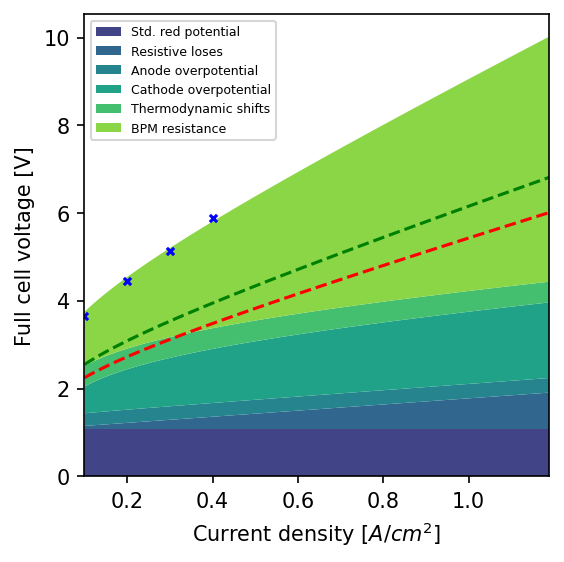

In [7]:

#-------------------------------------------------------------------- colors for the stackplot
# user to specify
source = ['Std. red potential', 'Resistive loses', 'Anode overpotential', 'Cathode overpotential', 'Thermodynamic shifts', 'BPM resistance'] # list of units to be stacked
pct_max = 95 # for example, max percentile of color ramp
pct_min = 20 # for example, min percentile of color ramp
ramp = plt.cm.viridis # for example

# number of items in data source
n = len(source)

# list of values between 0.00 and 1.00; length equals length of data source
n_prop = list(i / 100.0 for i in (np.arange(pct_min, pct_max, (pct_max-pct_min)/n)))

# create list of colors
clr_lst = []
for i in n_prop:
    clr = ramp(i) 
    clr_lst.append(clr)    
    
fig, ax = plt.subplots(figsize = (4,4), dpi =150)
ax.stackplot(l, V_SRParr, V_resis, V_overpanod, V_overpcath, V_nernstarr, V_BPM, labels = source,colors = clr_lst)

#sargent group data
CV_sar = [3.652, 4.448, 5.131, 5.891] 
J_sar  = [0.100, 0.200, 0.300, 0.400]
#J_shin = [0.100, 0.200, 0.300, 0.400,1.2]

V_FCV_BC = np.array([x*68/100 for x in V_FCV])
V_FCV_OC = np.array([x*60/100 for x in V_FCV])
#V_FCV_shin = np.array([6.4*x+3.0943 for x in J_shin])

ax.scatter(J_sar, CV_sar, marker = 'x', s=12, c='blue')
ax.plot(l, V_FCV_BC, 'g--')
ax.plot(l, V_FCV_OC, 'r--')
#ax.plot(J_shin, V_FCV_shin, 'b--')

ax.set_xlabel("Current density $[A/cm^2]$", fontsize =10)
ax.set_ylabel("Full cell voltage [V]", fontsize =10)
ax.legend(fontsize =6, loc = 'upper left')
ax.margins(x=0)

plt.show()